<a href="https://colab.research.google.com/github/swang63/CSC6370/blob/master/mRNA_Vaccine_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train = pd.read_json('/content/drive/MyDrive/Colab Notebooks/train.json', lines=True)
test = pd.read_json('/content/drive/MyDrive/Colab Notebooks/test.json', lines=True)
#create columns for y
pred_cols = ['reactivity', 
             'deg_Mg_pH10',
             'deg_Mg_50C',
             'deg_pH10',
             'deg_50C']

In [ ]:
#preprocess inputs X
def preprocess_inputs(df, 
                      token2int,
                      cols=['sequence', 'structure', 'predicted_loop_type']):
  return pandas_list_to_array(df[cols].applymap(lambda seq: [token2int[x] for x in seq]))


def pandas_list_to_array(df):
  return np.transpose(np.array(df.values.tolist()), 
                      (0, 2, 1))

def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def mcrmse(y_actual, y_pred, num_scored=len(pred_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

In [ ]:
token2int = {x: i for i, x in enumerate('().ACGUBEHIMSX')}
train_data = preprocess_inputs(train, token2int)
train_labels = pandas_list_to_array(train[pred_cols])

#train test split to get train and val set
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
                                                    test_size=0.25,
                                                    random_state=101,
                                                    stratify=train.SN_filter)

#train test split to get train and test set
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels,
                                                    test_size=0.25,
                                                    random_state=101)


In [ ]:
print(train)
#print(test)

      index            id                                           sequence  \
0         0  id_001f94081  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
1         1  id_0049f53ba  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   
2         2  id_006f36f57  GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...   
3         3  id_0082d463b  GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...   
4         4  id_0087940f4  GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...   
...     ...           ...                                                ...   
2395   2395  id_ff84602f7  GGAAAAUAGCAGAGGAAAUACUAGAGCAAUUGCAAAGGCCGAUCAU...   
2396   2396  id_ff85fcdba  GGAAAACAAAAACAAACAACAAAAACAAACAACAAAAACAAACAAC...   
2397   2397  id_ffa99f541  GGAAAGCCAUACCUAGGCUUCGGCCUAGGUAUGGCGGUGAUCUGGU...   
2398   2398  id_ffe06f3fe  GGAAACGAUAGCAGAAGAGAUCGAUAUAGAGCAUAAGCUAAGAAUA...   
2399   2399  id_fff546103  GGAAAGCUAGGACGUGGGAGCGUAGCUCUCCACACGGGUACGCCAA...   

                                       

In [ ]:
def MCRMSE(y_true, y_pred):
  colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
  return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [ ]:
def gru_layer(hidden_dim, dropout):
  return L.Bidirectional(L.GRU(hidden_dim,
                               dropout=dropout,
                               return_sequences=True,
                               kernel_initializer='orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

In [ ]:
def build_model(embed_size,
                model_type,
                seq_len=107,
                sp_dropout=0.3,
                n_layers=3,
                hidden_dim=256,
                pred_len=68,
                dropout=0.5):
  
  inputs = L.Input(shape=(seq_len, 3))

  embed = L.Embedding(input_dim=embed_size,
                      output_dim=200)(inputs)

  reshaped = tf.reshape(embed,
                      shape = (-1,
                               embed.shape[1],
                               embed.shape[2] * embed.shape[3]))
  
  hidden = L.SpatialDropout1D(sp_dropout)(reshaped)

  if (model_type == 1):
    for x in range(n_layers):
      hidden = lstm_layer(hidden_dim, dropout)(hidden)
  else:
    for x in range(n_layers):
      hidden = gru_layer(hidden_dim, dropout)(hidden)

  truncated = hidden[:, :pred_len]

  out = L.Dense(5, activation='linear')(truncated)

  model = tf.keras.Model(inputs=inputs,
                         outputs=out)
  
  model.compile(tf.optimizers.Adam(),
                loss=MCRMSE,
                metrics=['accuracy'])
  
  return model

In [ ]:
model_lstm = build_model(embed_size=len(token2int), model_type=1)
model_lstm.summary()
model_gru = build_model(embed_size=len(token2int), model_type=0)
model_gru.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 107, 3)]          0         
                                                                 
 embedding (Embedding)       (None, 107, 3, 200)       2800      
                                                                 
 tf.reshape (TFOpLambda)     (None, 107, 600)          0         
                                                                 
 spatial_dropout1d (SpatialD  (None, 107, 600)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 107, 512)         1755136   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 107, 512)         157491

In [ ]:
#fit batch 32
lstm_32 = model_lstm.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=100,
                    verbose=2,
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=5),
                               tf.keras.callbacks.ModelCheckpoint('lstm_model.h5')])
gru_32 = model_gru.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=100,
                    verbose=2,
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=5),
                               tf.keras.callbacks.ModelCheckpoint('gru_model.h5')])
#fit batch 64
lstm_64 = model_lstm.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=5),
                               tf.keras.callbacks.ModelCheckpoint('lstm_model1.h5')])
gru_64 = model_gru.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=5),
                               tf.keras.callbacks.ModelCheckpoint('gru_model2.h5')])

#fit batch 128
lstm_128 = model_lstm.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=128,
                    epochs=100,
                    verbose=2,
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=5),
                               tf.keras.callbacks.ModelCheckpoint('lstm_model3.h5')])
gru_128 = model_gru.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=128,
                    epochs=100,
                    verbose=2,
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=5),
                               tf.keras.callbacks.ModelCheckpoint('gru_model3.h5')])

Epoch 1/100
57/57 - 22s - loss: 0.6027 - accuracy: 0.2684 - val_loss: 0.5487 - val_accuracy: 0.3177 - lr: 0.0010 - 22s/epoch - 385ms/step
Epoch 2/100
57/57 - 4s - loss: 0.5251 - accuracy: 0.3190 - val_loss: 0.5231 - val_accuracy: 0.3551 - lr: 0.0010 - 4s/epoch - 63ms/step
Epoch 3/100
57/57 - 4s - loss: 0.5027 - accuracy: 0.3347 - val_loss: 0.5032 - val_accuracy: 0.3587 - lr: 0.0010 - 4s/epoch - 63ms/step
Epoch 4/100
57/57 - 4s - loss: 0.4890 - accuracy: 0.3453 - val_loss: 0.4939 - val_accuracy: 0.3528 - lr: 0.0010 - 4s/epoch - 63ms/step
Epoch 5/100
57/57 - 4s - loss: 0.4779 - accuracy: 0.3524 - val_loss: 0.4822 - val_accuracy: 0.3703 - lr: 0.0010 - 4s/epoch - 63ms/step
Epoch 6/100
57/57 - 4s - loss: 0.4702 - accuracy: 0.3719 - val_loss: 0.4763 - val_accuracy: 0.3862 - lr: 0.0010 - 4s/epoch - 70ms/step
Epoch 7/100
57/57 - 4s - loss: 0.4609 - accuracy: 0.3758 - val_loss: 0.4627 - val_accuracy: 0.3944 - lr: 0.0010 - 4s/epoch - 64ms/step
Epoch 8/100
57/57 - 4s - loss: 0.4522 - accuracy: 0.

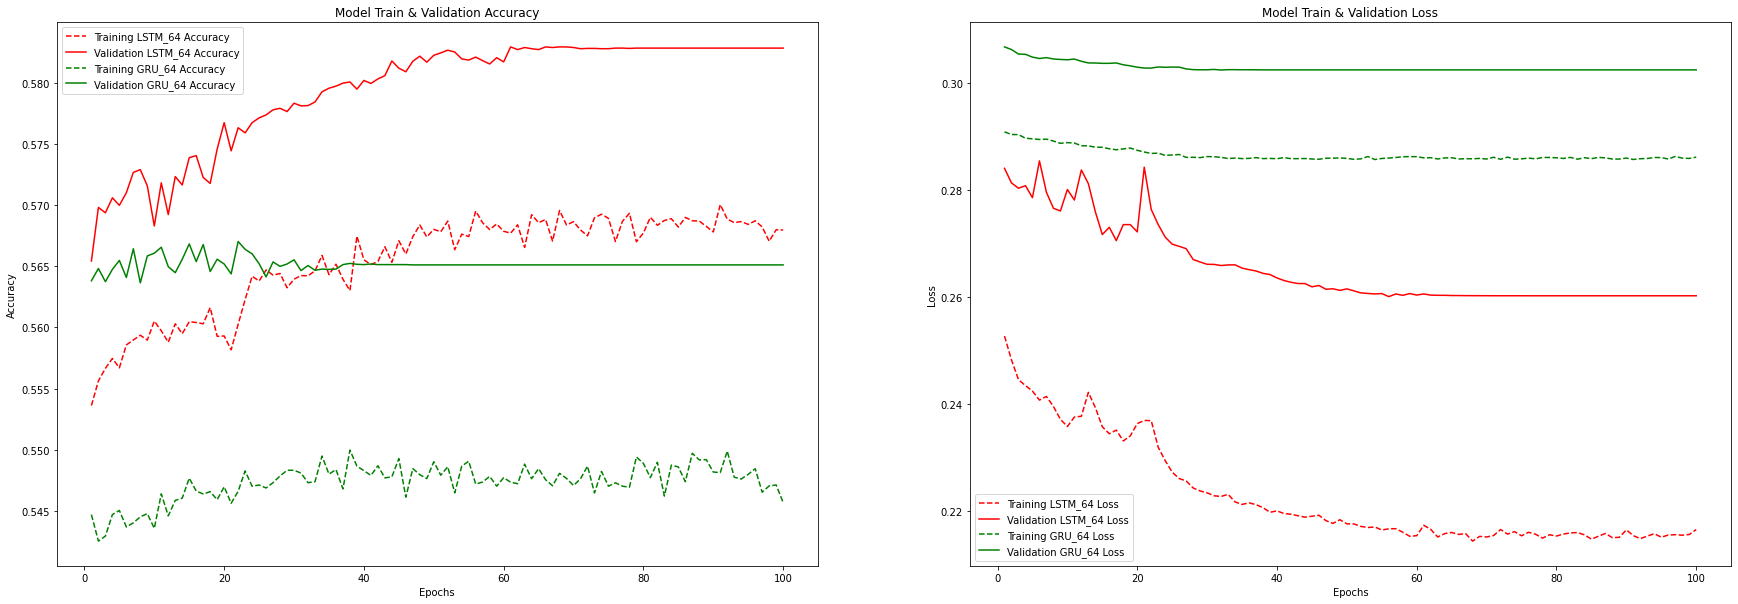

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(30, 10)

train_acc1 = lstm_32.history['accuracy']
train_loss1 = lstm_32.history['loss']
val_acc1 = lstm_32.history['val_accuracy']
val_loss1 = lstm_32.history['val_loss']

train_acc2 = gru_32.history['accuracy']
train_loss2 = gru_32.history['loss']
val_acc2 = gru_32.history['val_accuracy']
val_loss2 = gru_32.history['val_loss']

train_acc3 = lstm_64.history['accuracy']
train_loss3 = lstm_64.history['loss']
val_acc3 = lstm_64.history['val_accuracy']
val_loss3 = lstm_64.history['val_loss']

train_acc4 = gru_64.history['accuracy']
train_loss4 = gru_64.history['loss']
val_acc4 = gru_64.history['val_accuracy']
val_loss4 = gru_64.history['val_loss']

train_acc5 = lstm_128.history['accuracy']
train_loss5 = lstm_128.history['loss']
val_acc5 = lstm_128.history['val_accuracy']
val_loss5 = lstm_128.history['val_loss']

train_acc6 = gru_128.history['accuracy']
train_loss6 = gru_128.history['loss']
val_acc6 = gru_128.history['val_accuracy']
val_loss6 = gru_128.history['val_loss']

epochs = range(1, len(train_acc1) + 1)

ax[0].plot(epochs, train_acc3, 'r--', label = 'Training LSTM_64 Accuracy')
ax[0].plot(epochs , val_acc3, 'r', label = 'Validation LSTM_64 Accuracy')
ax[0].plot(epochs, train_acc4 ,'g--', label = 'Training GRU_64 Accuracy')
ax[0].plot(epochs , val_acc4 , 'g', label = 'Validation GRU_64 Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss3, 'r--' , label = 'Training LSTM_64 Loss')
ax[1].plot(epochs, val_loss3 ,'r', label = 'Validation LSTM_64 Loss')
ax[1].plot(epochs, train_loss4, 'g--' , label = 'Training GRU_64 Loss')
ax[1].plot(epochs, val_loss4 ,'g', label = 'Validation GRU_64 Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

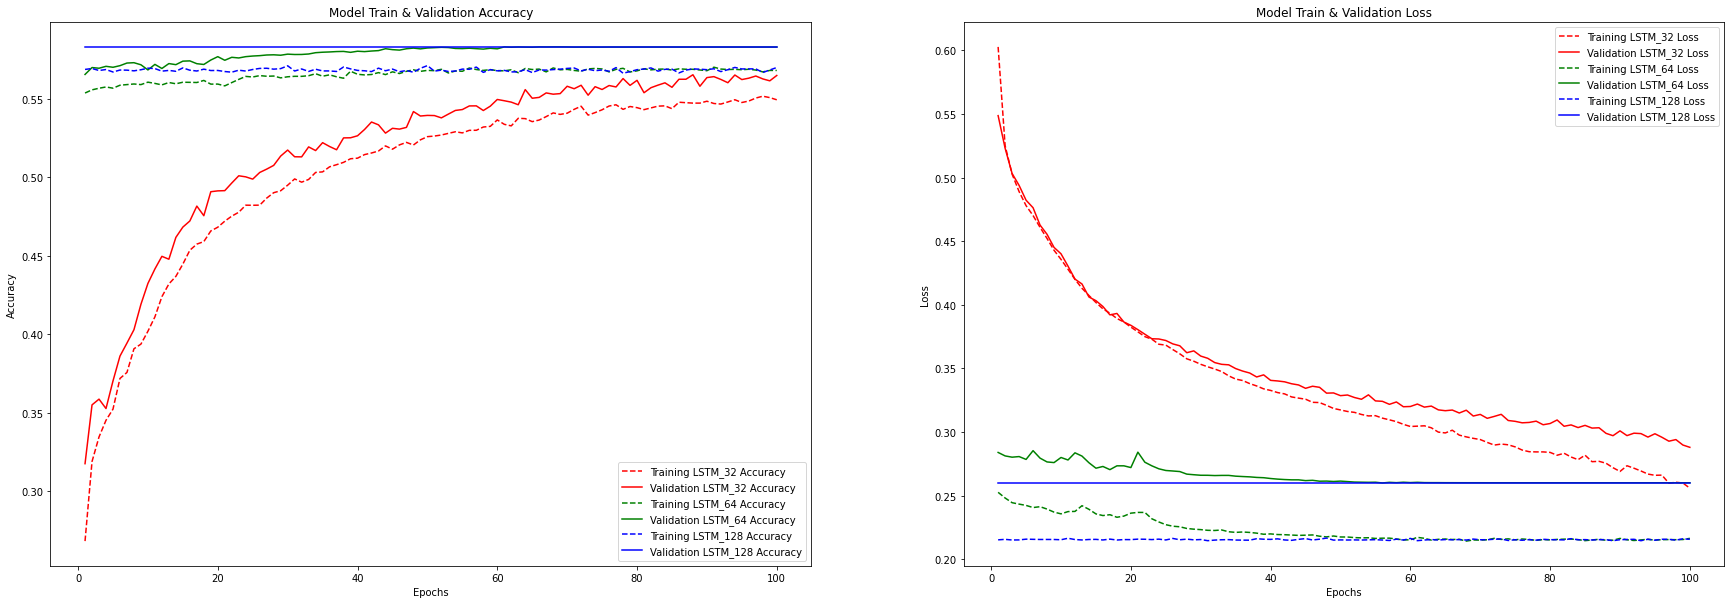

In [ ]:
# plot the training data
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(30, 10)


ax[0].plot(epochs, train_acc1, 'r--', label = 'Training LSTM_32 Accuracy')
ax[0].plot(epochs , val_acc1, 'r', label = 'Validation LSTM_32 Accuracy')
ax[0].plot(epochs, train_acc3 ,'g--', label = 'Training LSTM_64 Accuracy')
ax[0].plot(epochs , val_acc3 , 'g', label = 'Validation LSTM_64 Accuracy')
ax[0].plot(epochs, train_acc5 ,'b--', label = 'Training LSTM_128 Accuracy')
ax[0].plot(epochs , val_acc5 , 'b', label = 'Validation LSTM_128 Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
#box = ax[0].get_position()
#ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss1, 'r--' , label = 'Training LSTM_32 Loss')
ax[1].plot(epochs, val_loss1 ,'r', label = 'Validation LSTM_32 Loss')
ax[1].plot(epochs, train_loss3, 'g--' , label = 'Training LSTM_64 Loss')
ax[1].plot(epochs, val_loss3 ,'g' ,label = 'Validation LSTM_64 Loss')
ax[1].plot(epochs, train_loss5, 'b--' , label = 'Training LSTM_128 Loss')
ax[1].plot(epochs, val_loss5 ,'b', label = 'Validation LSTM_128 Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

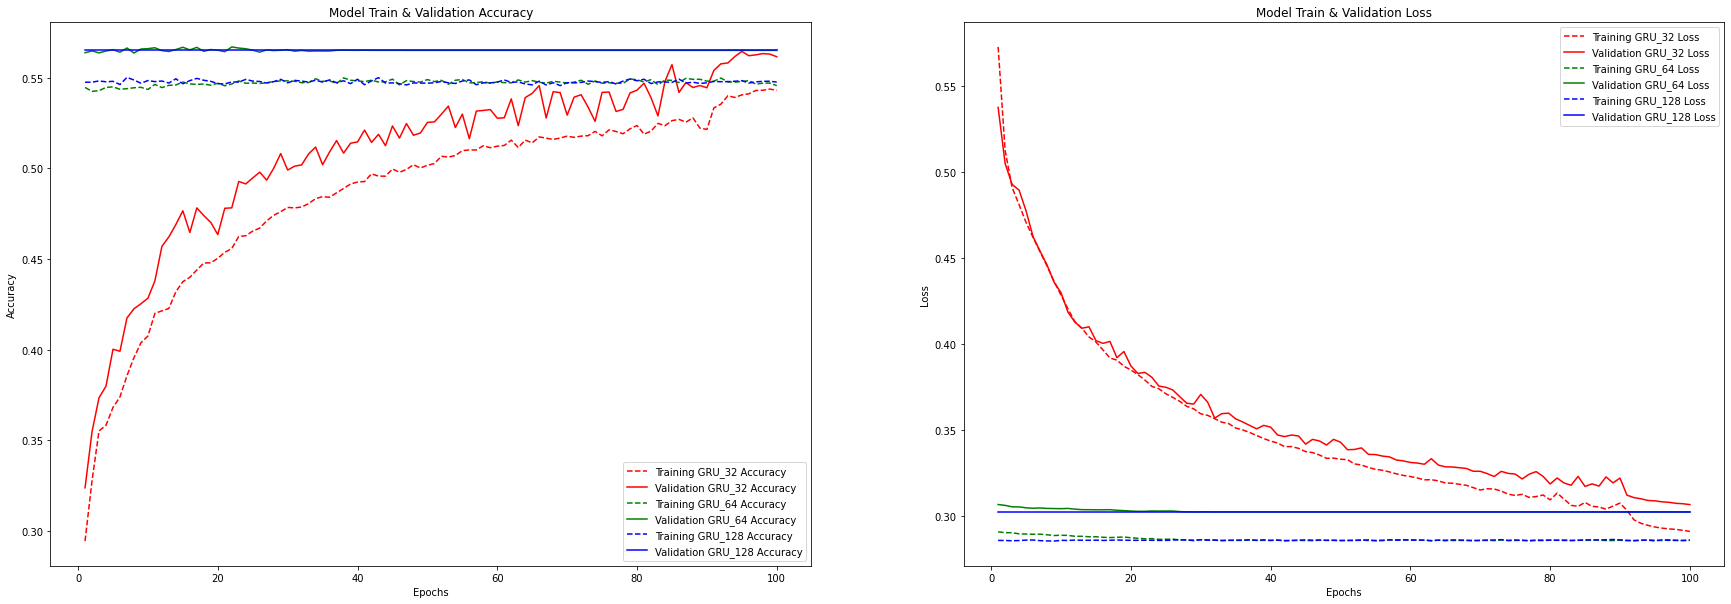

In [ ]:
# plot the training data
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(30, 10)

ax[0].plot(epochs, train_acc2, 'r--', label = 'Training GRU_32 Accuracy')
ax[0].plot(epochs , val_acc2, 'r', label = 'Validation GRU_32 Accuracy')
ax[0].plot(epochs, train_acc4 ,'g--', label = 'Training GRU_64 Accuracy')
ax[0].plot(epochs , val_acc4 , 'g', label = 'Validation GRU_64 Accuracy')
ax[0].plot(epochs, train_acc6 ,'b--', label = 'Training GRU_128 Accuracy')
ax[0].plot(epochs , val_acc6 , 'b', label = 'Validation GRU_128 Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
#box = ax[0].get_position()
#ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss2, 'r--' , label = 'Training GRU_32 Loss')
ax[1].plot(epochs, val_loss2 ,'r', label = 'Validation GRU_32 Loss')
ax[1].plot(epochs, train_loss4, 'g--' , label = 'Training GRU_64 Loss')
ax[1].plot(epochs, val_loss4 ,'g' ,label = 'Validation GRU_64 Loss')
ax[1].plot(epochs, train_loss6, 'b--' , label = 'Training GRU_128 Loss')
ax[1].plot(epochs, val_loss6 ,'b', label = 'Validation GRU_128 Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
#evaluate
print('LSTM Train loss & accuracy:', model_lstm.evaluate(X_train, y_train, batch_size=64))
print('\n')
print('LSTM Test loss & accuracy:', model_lstm.evaluate(X_test, y_test, batch_size=64))
print('\n')
#evaluate
print('GRU Train loss & accuracy:', model_gru.evaluate(X_train, y_train, batch_size=64))
print('\n')
print('GRU Test loss & accuracy:', model_gru.evaluate(X_test, y_test, batch_size=64))
print('\n')

29/29 [==============================] - 1s 50ms/step - loss: 0.1901 - accuracy: 0.5989
LSTM Train loss & accuracy: [0.19011586904525757, 0.5989460945129395]


10/10 [==============================] - 1s 49ms/step - loss: 0.4732 - accuracy: 0.4953
LSTM Test loss & accuracy: [0.47320282459259033, 0.4952695965766907]


29/29 [==============================] - 1s 50ms/step - loss: 0.2643 - accuracy: 0.5860
GRU Train loss & accuracy: [0.2643262445926666, 0.585964024066925]


10/10 [==============================] - 0s 27ms/step - loss: 0.4280 - accuracy: 0.4883
GRU Test loss & accuracy: [0.4279809594154358, 0.4883333444595337]




In [ ]:
#predict
y_pred1 = model_lstm.predict(X_test)
y_pred2 = model_gru.predict(X_test)

19/19 [==============================] - 2s 25ms/step


In [ ]:
#print predictions
print(y_pred1.shape)
#print(pd.DataFrame(y_pred[0]))
df = pd.DataFrame(y_pred1[0])
df.columns=['reactivity_pred',
               'deg_Mg_pH10_pred',
               'deg_Mg_50C_pred',
               'deg_pH10_pred',
               'deg_50C_pred']
print(df)

print(y_pred2.shape)
#print(pd.DataFrame(y_pred[0]))
df2 = pd.DataFrame(y_pred2[0])
df2.columns=['reactivity_pred',
               'deg_Mg_pH10_pred',
               'deg_Mg_50C_pred',
               'deg_pH10_pred',
               'deg_50C_pred']
print(df2)

(600, 68, 5)
    reactivity_pred  deg_Mg_pH10_pred  deg_Mg_50C_pred  deg_pH10_pred  \
0          0.450334          0.662258         0.447807       2.177353   
1          0.948908          2.023894         1.435952       2.345976   
2          1.186255          0.999278         1.265442       1.196052   
3          1.221565          0.617875         0.843587       0.915850   
4          1.100845          0.654177         0.679138       0.809139   
..              ...               ...              ...            ...   
63         0.516237          0.209129         0.280846       0.353426   
64         0.283864          0.314355         0.362123       0.334183   
65         0.043919          0.254508         0.338257       0.341093   
66         0.154679          0.287883         0.324250       0.537598   
67         0.085874          0.343509         0.259829       0.529520   

    deg_50C_pred  
0       0.699401  
1       1.318699  
2       1.195948  
3       1.202571  
4       0.89544

In [ ]:
def degradation_sample(index):
  #create columns for y
  original_cols = ['reactivity',
                   'deg_Mg_pH10',
                   'deg_Mg_50C',
                   'deg_pH10',
                   'deg_50C']
  pred_cols = ['reactivity_pred',
               'deg_Mg_pH10_pred',
               'deg_Mg_50C_pred',
               'deg_pH10_pred',
               'deg_50C_pred'] 

  predicted_df = pd.DataFrame(y_pred1[index], columns=pred_cols)
  original_df = pd.DataFrame(y_test[index], columns=original_cols)
  orig_pred_df = pd.concat([original_df, predicted_df], axis=1)

  return orig_pred_df

In [ ]:
#predict sample
LSTM_results = degradation_sample(4)

In [ ]:
print(LSTM_results)


    reactivity  deg_Mg_pH10  deg_Mg_50C  deg_pH10  deg_50C  reactivity_pred  \
0       0.5267       0.3756      0.0664    1.8509   0.3431         0.219339   
1       0.3994       0.6038      0.5503    1.3724   1.4058         0.657194   
2       0.3687       0.2568      0.4342    0.7989   0.8602         0.531756   
3       0.5640       0.3497      0.3514    0.6849   0.4988         0.491343   
4       0.3506       0.3314      0.2104    0.1349   0.2463         0.207764   
..         ...          ...         ...       ...      ...              ...   
63      0.1175       0.3407      0.3437    0.1189   0.1733         0.118719   
64      0.3117       0.8999      1.1857    0.7543   0.7477         0.201973   
65      0.2752       0.4046      0.3399    0.1159   0.3027         0.304148   
66      0.0059       0.1660      0.1832    0.1224   0.1017         0.068407   
67      0.0162       0.3386      0.3498    0.2013   0.1503         0.079703   

    deg_Mg_pH10_pred  deg_Mg_50C_pred  deg_pH10_pre

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3634 entries, 0 to 3633
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                3634 non-null   int64 
 1   id                   3634 non-null   object
 2   sequence             3634 non-null   object
 3   structure            3634 non-null   object
 4   predicted_loop_type  3634 non-null   object
 5   seq_length           3634 non-null   int64 
 6   seq_scored           3634 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 198.9+ KB


In [ ]:
#print(test)

      index            id                                           sequence  \
0         0  id_00073f8be  GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...   
1         1  id_000ae4237  GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...   
2         2  id_00131c573  GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...   
3         3  id_00181fd34  GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...   
4         4  id_0020473f7  GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...   
...     ...           ...                                                ...   
3629   3629  id_ff691b7e5  GGAAACUAGCCAUGGGCAGGUUGAAGGUUGGGUGACACUAACUGGA...   
3630   3630  id_ff9bf3581  GGAAAUAGCGCCAUAGCCGAUUAUUAUAGGCAAUUUUAGCGAUUUA...   
3631   3631  id_ffc8f96a8  GGAAAGAUGUUCUGAUGAACAUCGGCUGUUCUAGCUUUCAUCUAUC...   
3632   3632  id_ffd7e8cc1  GGAAACCGUUAACCUGCAUCUUCAUGUUAUCGCUUGCGACAGCAAC...   
3633   3633  id_ffda94f24  GGAAAAACCAAUUGCUAUUAAAGGUUCCUUUGUUCGCUAAGUCCAA...   

                                       

In [ ]:
public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")

public_inputs = preprocess_inputs(public_df, token2int)
private_inputs = preprocess_inputs(private_df, token2int)

In [ ]:
pub_res_lstm = model_lstm.predict(public_inputs)
pub_res_lstm = model_gru.predict(public_inputs)

20/20 [==============================] - 1s 27ms/step


In [ ]:
print(pub_res_lstm.shape)
print(pub_res_lstm)

(629, 68, 5)
[[[0.8334973  0.8391827  0.5927076  2.0750742  0.7307589 ]
  [2.425431   3.4549217  3.042314   3.9680326  2.8938093 ]
  [1.9304975  0.8147856  0.7837071  0.86414814 0.74973124]
  ...
  [0.26762268 0.49507543 0.5368781  0.30019656 0.34439838]
  [0.17312333 0.58604383 0.61368114 0.47896135 0.45465732]
  [0.15614946 0.61869824 0.5131021  0.67006    0.472685  ]]

 [[0.46184623 0.7544203  0.58504707 2.0131252  0.68030655]
  [1.3788625  2.0940475  2.0894608  3.1823165  2.0306232 ]
  [1.4096953  0.8953192  1.2778502  1.0667512  1.1642587 ]
  ...
  [0.34032696 0.75756955 0.9698132  0.7523492  0.61480576]
  [0.34779832 0.61533594 0.728739   0.39855865 0.45334056]
  [0.4062609  0.4514691  0.29183713 0.5681922  0.36945465]]

 [[0.50626254 0.4917674  0.50648654 1.5888866  0.6255275 ]
  [1.5972456  1.5353429  1.5821574  2.4499917  1.672404  ]
  [1.5446316  0.98928165 1.5908229  1.4354352  1.3042669 ]
  ...
  [0.70203936 1.2909725  1.3677211  1.1332331  1.1018634 ]
  [0.20830715 0.45008